# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.


## In this exercise you will perform the following:
1. Implement two impurity measures: Gini and Entropy.
2. Construct a decision tree algorithm.
3. Prune the tree to achieve better results.
4. Visualize your results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# addng imports
from queue import LifoQueue
from queue import Queue

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [3]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [4]:
#############################################################################
# TODO: Find the columns with missing values and remove them from the data.#
#############################################################################
col_missing = data.columns[data.isnull().any()].tolist()
data = data.drop(col_missing, axis=1)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

We will split the dataset to `Training` and `Testing` datasets.

In [5]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [6]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    shape = data.shape[0]
    _, counts = np.unique(data[:,-1:], return_counts=True)
    gini = 1 - sum((counts/shape)**2)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return gini

In [7]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    shape = data.shape[0]
    _, counts = np.unique(data[:,-1:], return_counts=True)
    P = counts / shape
    logP = np.log2(P)
    entropy = sum(-P*logP)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return entropy

In [8]:
##### Your Tests Here #####
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [9]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
       
    unique_values, counts = np.unique(data[:,feature], return_counts=True)
    shape = data.shape[0]
    sigma = 0
    for value, count in zip(unique_values, counts):
        value_data = data[data[:,feature]==value]
        sigma += (count/shape)*impurity_func(value_data)
            
    goodness = impurity_func(data) - sigma
    
    if gain_ratio:
        S = counts / shape
        logS = np.log2(S)
        split_info = np.sum(-S*logS)
        if split_info != 0:
            goodness = goodness / split_info # gain ratio
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return goodness    

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [10]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, data, impurity, value='root'):
        self.feature_was_split = -1 # column index of criteria being tested
        self.feature_to_split = -1 # the best feature to split by
        self.value = value # the value in which the Node is duplicated by
        self.avb_features = [f for f in range(data.shape[1]-1)]
        self.data = data  
        self.children = []
        self.impurity_func = impurity
        self.depth = 0
        self.label = 'label'
        
    def __str__(self):
        return str(self.feature_was_split)+" "+str(self.value)+" "+str(self.label)+" "+str([(c.feature_was_split, c.value) for c in self.children])
        
    def add_child(self, node):
        self.children.append(node)
            
    def find_best_split(self, gain_ratio=False):
        d = {}
        for feature in self.avb_features:
            d[feature] = goodness_of_split(self.data, feature, self.impurity_func, gain_ratio)
        
        if max(d.values()) == 0:
            return -1
        
        return max(d, key=d.get)
    
    
    def split_data_set(self, feature, value):
        new_data = self.data[np.where(self.data[:,feature]==value)]
        return new_data if all(new_data.shape) else None
      
    def create_children(self, feature):
        values = np.unique(self.data[:,feature]) #find unique values (labels)
        for value in values:
            self.create_child(feature, value)
    
    def create_child(self, feature, value):
            data = self.split_data_set(feature, value)
            if data is not None:
                child = DecisionNode(data, self.impurity_func)
                child.value = value #data[0, feature] #=value
                child.depth = self.depth + 1
                child.avb_features = [f for f in self.avb_features if f != feature]
                child.feature_was_split = feature
                # find the most common label
                labels, counts = np.unique(child.data[:,-1:], return_counts=True)
                child.label = labels[np.argmax(counts)]
                
                self.add_child(child)
       


In [11]:
def build_tree(data, impurity, gain_ratio=False, chi=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the raining dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - chi: chi square p-value cut off (1 means no pruning)
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    nodes_queue = Queue() # queue to hold the node
    
    # intinliaze the root node
    root = DecisionNode(data, impurity)
    nodes_queue.put(root)
    
    while nodes_queue.empty() is not True:
        # if the queue is empty then stop
        try:   
            node = nodes_queue.get_nowait()
        except:
            continue
                 
        # stop conditions:
        # no avaible feature
        # max depth
        # pure node
        if node.avb_features == [] or node.depth == max_depth or len(np.unique(node.data[:,-1:])) == 1:
            continue
            
        best_feature = node.find_best_split(gain_ratio)
        node.feature_to_split = best_feature
        if best_feature == -1:
            continue
            
        else:
            if chi!=1:
                chi_check = chi_square(node.data, best_feature)
                num_of_att = np.unique(node.data[:,best_feature]) #find unique values (labels)
                deg_of_freedome = len(num_of_att) - 1
            
                if chi_check > chi_table[deg_of_freedome][chi]:
                    node.create_children(node.find_best_split(gain_ratio))
                    for child in node.children: # add the new childern nodes to the queue
                        nodes_queue.put(child)
                else:
                    continue
                        
            else:
                node.create_children(best_feature)
                for child in node.children: # add the new childern nodes to the queue
                    nodes_queue.put(child)
        
        
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return root


In [12]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [13]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    flag = False
    
    while True:
        if node.children == [] or flag:
            return node.label
        
        value = instance[node.feature_to_split]
           
        for child in node.children:
            if child.value == value:
                node = child
                flag = False
                break
            else:
                flag = True
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return node.pred

In [14]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    m, _ = dataset.shape
    counter = 0
    for i in range(m):
        instance = dataset[i]
        pred = predict(node, instance)
        if pred == instance[-1]:
            counter += 1
    accuracy = counter / m
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag).

In [15]:
trees = {'tree_gini': tree_gini, 
         'tree_entropy': tree_entropy,
         'tree_entropy_gain_ratio': tree_entropy_gain_ratio}

for name, tree in trees.items():
    train_acc = calc_accuracy(tree, X_train)
    test_acc = calc_accuracy(tree, X_test)
    print('{}: train: {:.3f}, test: {:.4f}'.format(name, train_acc, test_acc))

tree_gini: train: 0.992, test: 0.7750
tree_entropy: train: 0.994, test: 0.7725
tree_entropy_gain_ratio: train: 0.996, test: 0.7853


## Post pruning

Iterate over all nodes in the tree that have at least a single child which is a leaf. For each such node, replace it with its most popular class. Calculate the accuracy on the testing dataset, pick the node that results in the highest testing accuracy and permanently change it in the tree. Repeat this process until you are left with a single node in the tree (the root). Finally, create a plot of the training and testing accuracies as a function of the number of nodes in the tree. (15 points)

In [16]:
# This is the exact function from the "Number of nodes part"
# We are using it here also
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    nodes_queue = Queue() # queue to hold the node
    count = 0

    nodes_queue.put(node) # insert the root node
    while nodes_queue.empty() is not True:
        # if the queue is empty then stop
        try:   
            node = nodes_queue.get_nowait()
        except:
            continue
        
        count += 1

        for child in node.children:
            nodes_queue.put(child)
    
    return count
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

In [17]:
def find_node_to_remove(root):
    # condition = at least one child which is a leaf
    node_list = [] # will hold all the nodes with the condition
    node_queue = Queue()
    leaf = False
    
    node_queue.put(root)
    while node_queue.empty() is not True:
        # if the queue is empty then stop
        try:
            node = node_queue.get_nowait()
        except:
            continue
            
        for child in node.children:
            if child.children == []:
                leaf = True
            node_queue.put(child)
            
        if leaf:
            node_list.append(node)
            leaf = False
            
    return node_list

def build_plot(number_of_nodes, train_acc, test_acc):
    plt.plot(number_of_nodes, train_acc, color='g')
    plt.plot(number_of_nodes, test_acc, color='b')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy as a function of the number of nodes')
    plt.legend(['Train Accuracy', 'Test Accuracy']);
    plt.show()


def change_tree(root, check=0):
    
    number_of_nodes = []
    train_acc = []
    test_acc = []
    
    # Save parameters of the initial tree
    number_of_nodes.append(count_nodes(root))
    train_acc.append(calc_accuracy(root, X_train))
    test_acc.append(calc_accuracy(root, X_test))
    
    nodes_to_check = find_node_to_remove(root)
    
    while root.children:
        max_accur = 0
        best_node_to_remove = []
        for node in nodes_to_check:
            temp_node_children = node.children
            node.children = []
            curr_accur = calc_accuracy(root, X_test)

            if curr_accur > max_accur:
                best_node_to_remove = node
                max_accur = curr_accur

            node.children = temp_node_children    

        best_node_to_remove.children = []
        
        # Save parameters of the new prunned tree
        number_of_nodes.append(count_nodes(root))
        train_acc.append(calc_accuracy(root, X_train))
        test_acc.append(calc_accuracy(root, X_test))
        nodes_to_check = find_node_to_remove(root)
        if len(nodes_to_check) == 1 and check == 0: # Stop when we arrive to the root
            best_num_of_nodes = number_of_nodes[test_acc.index(max(test_acc))]
            print(f"The best tree is recieved using {best_num_of_nodes} nodes")
            build_plot(number_of_nodes, train_acc, test_acc)
            break
        if check == number_of_nodes[-1]:
            return root

The best tree is recieved using 185 nodes


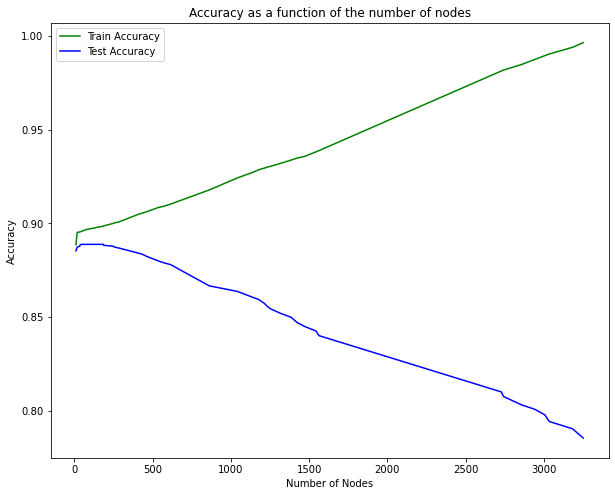

In [18]:
tree_post_pruning = change_tree(tree_entropy_gain_ratio)

## Chi square pre-pruning

Consider the following p-value cut-off values: [1 (no pruning), 0.5, 0.25, 0.1, 0.05, 0.0001 (max pruning)]. For each value, construct a tree and prune it according to the cut-off value. Next, calculate the training and testing accuracy. On a single plot, draw the training and testing accuracy as a function of the tuple (p-value, tree depth). Mark the best result on the graph with red circle. (15 points)

In [19]:
def tree_highet(root):
    node_queue = Queue()
    highet = 0
    node_queue.put(root)
    while node_queue.empty() is not True:
        # if the queue is empty then stop
        try:   
            node = node_queue.get_nowait()
        except:
            continue
        
        if node.depth > highet:
            highet = node.depth
        
        for child in node.children:
            node_queue.put(child)
    
    return highet

In [20]:
### Chi square table values ###
# The first key is the degree of freedom 
# The second key is the p-value cut-off
# The values are the chi-statistic that you need to use in the pruning
chi_table = {1: {0.5 : 0.45,
                 0.25 : 1.32,
                 0.1 : 2.71,
                 0.05 : 3.84,
                 0.0001 : 100000},
             2: {0.5 : 1.39,
                 0.25 : 2.77,
                 0.1 : 4.60,
                 0.05 : 5.99,
                 0.0001 : 100000},
             3: {0.5 : 2.37,
                 0.25 : 4.11,
                 0.1 : 6.25,
                 0.05 : 7.82,
                 0.0001 : 100000},
             4: {0.5 : 3.36,
                 0.25 : 5.38,
                 0.1 : 7.78,
                 0.05 : 9.49,
                 0.0001 : 100000},
             5: {0.5 : 4.35,
                 0.25 : 6.63,
                 0.1 : 9.24,
                 0.05 : 11.07,
                 0.0001 : 100000},
             6: {0.5 : 5.35,
                 0.25 : 7.84,
                 0.1 : 10.64,
                 0.05 : 12.59,
                 0.0001 : 100000},
             7: {0.5 : 6.35,
                 0.25 : 9.04,
                 0.1 : 12.01,
                 0.05 : 14.07,
                 0.0001 : 100000},
             8: {0.5 : 7.34,
                 0.25 : 10.22,
                 0.1 : 13.36,
                 0.05 : 15.51,
                 0.0001 : 100000},
             9: {0.5 : 8.34,
                 0.25 : 11.39,
                 0.1 : 14.68,
                 0.05 : 16.92,
                 0.0001 : 100000},
             10: {0.5 : 9.34,
                  0.25 : 12.55,
                  0.1 : 15.99,
                  0.05 : 18.31,
                  0.0001 : 100000},
             11: {0.5 : 10.34,
                  0.25 : 13.7,
                  0.1 : 17.27,
                  0.05 : 19.68,
                  0.0001 : 100000}}

In [21]:
def chi_square(node_data, feature): 
    
    chi_sqr = []
    chi_sqr_sum = 0
    
    parent_df = pd.DataFrame(node_data[:, feature], columns=['feature'])
    parent_df['class'] = node_data[:, -1]
    
    
    children = np.unique(parent_df['feature']) #find unique values (labels)
    parent_e = (parent_df['class'] == 'e').sum()
    parent_p = (parent_df['class'] == 'p').sum()

    e_percent = parent_e / (parent_e + parent_p)
    p_percent = parent_p / (parent_e + parent_p)
    

    for child in children:
        mask = parent_df['feature'] == child
        test = parent_df[mask][['class']].reset_index(drop=True)

        e_actual = (test['class'] == 'e').sum()
        p_actual = (test['class'] == 'p').sum()
                
        e_expect = (e_actual + p_actual) * e_percent
        p_expect = (e_actual + p_actual) * p_percent
        
        e_chi = ((e_actual-e_expect)**2) / (e_expect)
        p_chi = ((p_actual-p_expect)**2) / (p_expect)
        
        chi_sqr.append(e_chi)
        chi_sqr.append(p_chi)
        

    for i in chi_sqr:
        chi_sqr_sum += i
        
    return chi_sqr_sum
        

The best tree is recieved using P-value 0.05


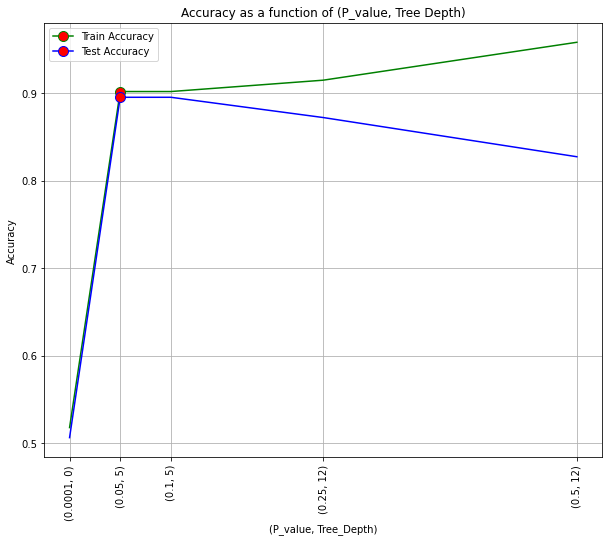

In [22]:
test_acc = []
train_acc = []
pval_depth = []
pvals = []
p_vals_arr=[0.5, 0.25, 0.1, 0.05, 0.0001]
p_vals_arr.sort()

for pval in p_vals_arr:
    tree_chi = build_tree(X_train, calc_entropy, chi=pval, gain_ratio=True)
    pvals.append(pval)
    train_acc_val = calc_accuracy(tree_chi, X_train)
    test_acc_val = calc_accuracy(tree_chi, X_test)
    pval_depth.append((pval, tree_highet(tree_chi)))
    if train_acc_val or test_acc_val:
        train_acc.append(train_acc_val)
        test_acc.append(test_acc_val)
    else:
        train_count_e = np.sum(X_train[:,-1] == 'e')
        test_count_e = np.sum(X_test[:,-1] == 'e')
        train_count_p = np.sum(X_train[:,-1] == 'p')
        test_count_p = np.sum(X_test[:,-1] == 'p')
        if test_count_e > test_count_p:
            train_acc_val = train_count_e / X_train.shape[0]
            test_acc_val = test_count_e / X_test.shape[0]
            train_acc.append(train_acc_val)
            test_acc.append(test_acc_val)
        else:
            train_acc_val = train_count_p / X_train.shape[0]
            test_acc_val = test_count_p / X_test.shape[0]
            train_acc.append(train_acc_val)
            test_acc.append(test_acc_val)

best_pval_plot = test_acc.index(max(test_acc)) 
best_pval = pvals[test_acc.index(max(test_acc))]
print(f"The best tree is recieved using P-value {best_pval}")


plt.plot(pvals, train_acc, markevery = [best_pval_plot], marker = "o", markerfacecolor = 'red', markersize = 10, color='g')
plt.plot(pvals, test_acc, markevery = [best_pval_plot], marker = "o", markerfacecolor = 'red', markersize = 10, color='b')
plt.xlabel('(P_value, Tree_Depth)')
plt.xticks(pvals, pval_depth , rotation ='vertical')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of (P_value, Tree Depth)')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.grid(True)
plt.show()

Build the best 2 trees:
1. tree_post_pruning - the best tree according to post pruning
2. tree_chi - the best tree according to chi square pruning

In [23]:
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # rebuild the tree
tree_post_pruning = change_tree(tree_entropy_gain_ratio, check=185) #tree_post_pruning

tree_chi = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, chi=0.05) #tree_chi

## Number of Nodes

Of the two trees above we will choose the one with fewer nodes. Complete the function counts_nodes and print the number of nodes in each tree. (5 points) 

In [24]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    nodes_queue = Queue() # queue to hold the node
    count = 0

    nodes_queue.put(node) # insert the root node
    while nodes_queue.empty() is not True:
        # if the queue is empty then stop
        try:   
            node = nodes_queue.get_nowait()
        except:
            continue
        
        count += 1

        for child in node.children:
            nodes_queue.put(child)
    
    return count
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    

## Print the tree

Complete the function `print_tree` and execute it on your chosen tree. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [25]:
# you can change the function signeture
def print_tree(node):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    def string_node(node):
        # the function will print the node
        
        string = '[X{}={}, feature=X{}]'.format(node.feature_was_split, node.value, node.feature_to_split)
        
        #if the node is the root
        if node.feature_was_split == -1:
            string = '[root, feature=X{}]'.format(node.feature_to_split)
            
        # if the node is a leaf, calculate his lables
        if node.children == []:
            uniques, counts = np.unique(node.data[:,-1:], return_counts=True)
            labels = {u: c for u, c in zip(uniques, counts)}
            string = '[X{}={}, leaf]: {}'.format(node.feature_was_split, node.value, labels)
        return string
    
    
    nodes_queue = LifoQueue() # queue to hold the node
    
    nodes_queue.put(node)
    while nodes_queue.empty() is not True:
        # if the queue is empty then stop
        try:   
            node = nodes_queue.get_nowait()
        except:
            continue
            
        string = " "*node.depth*3 + string_node(node)
        print(string)
        
        for child in node.children:
            nodes_queue.put(child)
            
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

In [26]:
print_tree(tree_entropy_gain_ratio)

[root, feature=X4]
   [X4=y, leaf]: {'e': 49, 'p': 382}
   [X4=s, feature=X13]
      [X13=w, leaf]: {'e': 26, 'p': 190}
      [X13=p, feature=X11]
         [X11=s, feature=X0]
            [X0=x, feature=X1]
               [X1=y, feature=X20]
                  [X20=p, feature=X2]
                     [X2=n, feature=X10]
                        [X10=s, feature=X12]
                           [X12=w, leaf]: {'p': 1}
                           [X12=p, leaf]: {'e': 1}
                        [X10=k, leaf]: {'p': 1}
                     [X2=e, leaf]: {'p': 3}
                  [X20=l, leaf]: {'p': 4}
                  [X20=d, leaf]: {'p': 7}
               [X1=s, leaf]: {'p': 18}
            [X0=k, leaf]: {'p': 30}
            [X0=f, feature=X20]
               [X20=p, feature=X2]
                  [X2=n, feature=X1]
                     [X1=y, leaf]: {'p': 4}
                     [X1=s, feature=X10]
                        [X10=s, feature=X12]
                           [X12=w, leaf]: {'p':